In [36]:
from flakylib import *
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt

In [56]:
@njit(parallel=True)
def number_of_clusters(samples, min_num=-1, max_num=-1, max_iters=300, tol=0.0001):
    n_samples = samples.shape[0]
    n_features = samples.shape[1]
    
    if min_num < 2 or min_num > n_samples:
        min_num = 2
    if max_num < 0 or max_num > n_samples:
        max_num = n_samples

    if n_samples > 0 and n_features > 0 and min_num < max_num:

        objectives = np.full(max_num, 0.0)

        used_samples = np.full(n_samples, False)
        global_centroid = np.reshape(np.sum(samples, axis=0) / n_samples, (1, samples.shape[1]))

        D = distance_matrix_euclidean2_XY_cpu(global_centroid, samples)
        medoid_ind = np.argmin(D[0])

        n_centroids = 1

        sample_weights, sample_membership, sample_objectives, centroids2, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_centroids)
        centroids2[0, :] = samples[medoid_ind, :]

        centroids = np.full((max_num, n_features), np.nan)
        centroids[0, :] = samples[medoid_ind, :]
        used_samples[medoid_ind] = True

        objectives[0], _ = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids2, centroid_objectives)

        local_objectives = np.empty(n_samples)

        for i in range(1, max_num):

            local_objectives.fill(np.inf)

            for j in prange(n_samples):

                if not used_samples[j]:
                    sample_weights, sample_membership, sample_objectives, centroids2, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_centroids)

                    centroids2 = np.concatenate((centroids[:n_centroids], np.reshape(samples[j], (1, samples.shape[1]))))
                    local_objectives[j], _ = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids2, centroid_objectives)

            min_ind = np.argmin(local_objectives)
            used_samples[min_ind] = True
            centroids[n_centroids, :] = samples[min_ind, :]
            objectives[n_centroids] = local_objectives[min_ind]
            n_centroids += 1

        cluster_nums = np.arange(min_num, max_num)
        drop_rates = np.empty(cluster_nums.shape[0])

        for i in range(min_num - 1, max_num - 1):

            p1 = objectives[i - 1]
            p2 = objectives[i]
            p3 = objectives[i + 1]

            d1 = abs(p1 - p2)
            d2 = abs(p2 - p3)
            
            #d1 = p1 - p2
            #d2 = p2 - p3

            if d2 != 0.0:
                drop_rates[i - min_num + 1] = d1 / d2
            else:
                drop_rates[i - min_num + 1] = 0.0

        n_clusters = cluster_nums[np.argmax(drop_rates)]
    else:
        n_clusters = -1
        cluster_nums = np.full(0, -1)
        drop_rates = np.empty(0)
        objectives = np.empty(0)
        
            
            

    return n_clusters, cluster_nums, drop_rates, objectives


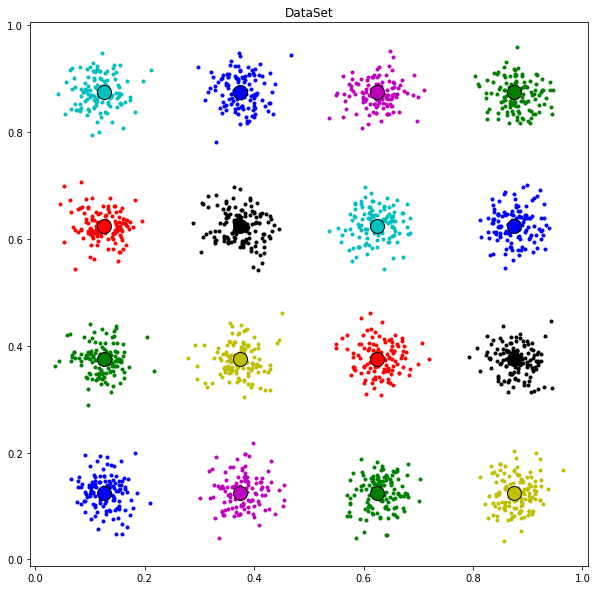

In [82]:
grid_size = 4
n_features = 2
n_samples = 2000
standard_deviation = 0.03
n_candidates = 3

samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
true_n_clusters = true_centroids.shape[0]



In [83]:
%%time
n_clusters, cluster_nums, drop_rates, objectives = number_of_clusters(samples, min_num = 2, max_num = 30)

print('Computed number of clusters: ', n_clusters)
print('True number of clusters: ', true_n_clusters)
print('')

Computed number of clusters:  25
True number of clusters:  16

CPU times: user 18.6 s, sys: 248 ms, total: 18.9 s
Wall time: 2.82 s


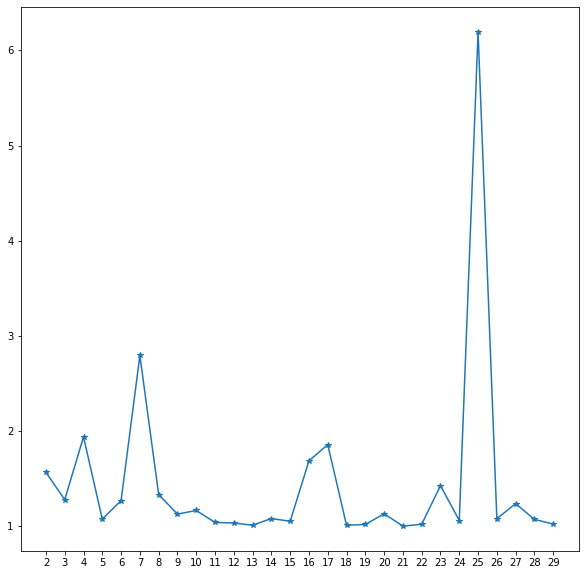

In [84]:
plt.xticks(np.arange(min(cluster_nums), max(cluster_nums)+1, 1.0))
plt.plot(cluster_nums, drop_rates, '-*')
plt.show()

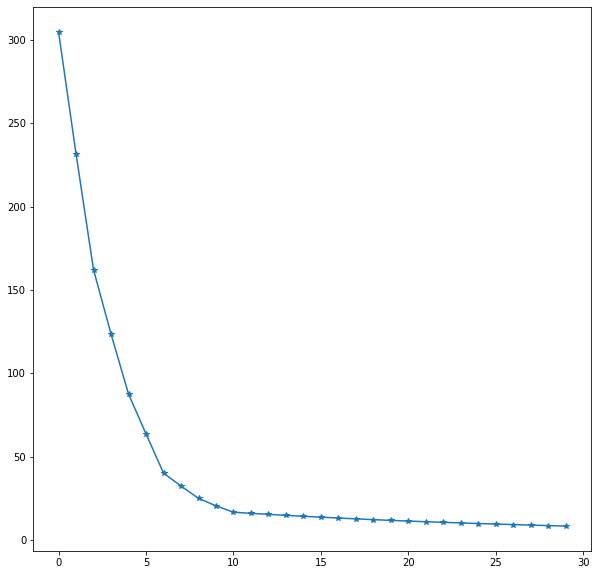

In [77]:
plt.plot(objectives,'*-')

In [5]:
cluster_nums.shape

(18,)

In [4]:
drop_rates.shape

(0,)

In [5]:
objectives.shape

(20,)

In [6]:
drop_rates.shape

(0,)

In [8]:
cluster_nums.shape

(18,)

In [10]:
len(drop_rates)

18

In [6]:
len(drop_rates)

18

In [13]:
import pickle

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
        
def save_obj(obj, name):
    pickle.dump(obj,open(name + '.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
  

In [14]:
samples = load_obj('test_vecs')

In [15]:
samples.shape

(275, 768)

In [18]:
%%time
n_clusters, cluster_nums, drop_rates, objectives = number_of_clusters(samples, min_num = 2, max_num = 20)
#n_clusters, cluster_nums, drop_rates, objectives = number_of_clusters(samples)

print('Computed number of clusters: ', n_clusters)
print('True number of clusters: ', true_n_clusters)
print('')

Computed number of clusters:  4
True number of clusters:  9

CPU times: user 22.3 s, sys: 376 ms, total: 22.7 s
Wall time: 3.55 s


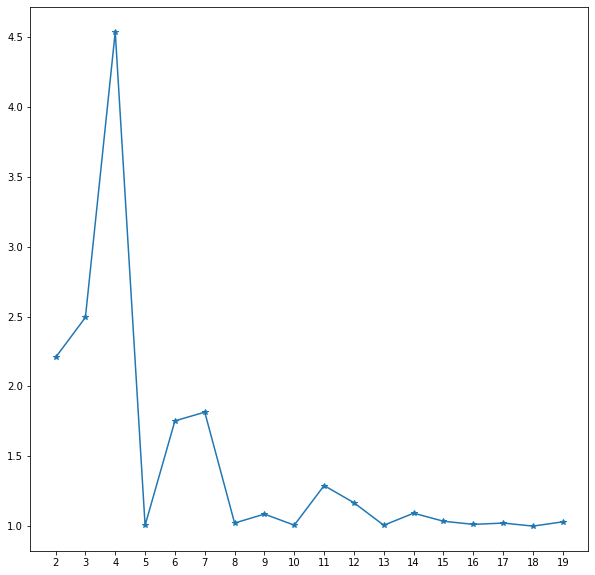

In [19]:
plt.xticks(np.arange(min(cluster_nums), max(cluster_nums)+1, 1.0))
plt.plot(cluster_nums, drop_rates, '-*')
plt.show()

In [37]:
drop_rates

array([-1.36311572e+57,  3.41012518e+00,  1.94719788e+00,  1.48717052e+00,
        2.16573557e+00,  1.37161749e+00,  1.06182717e+00,  1.33348387e+00,
        1.35020224e+00,  1.07209336e+00,  1.15307920e+00,  9.92575588e-01,
        1.14655564e+00,  1.04653207e+00,  1.05274672e+00,  1.00046172e+00,
        1.02960078e+00])

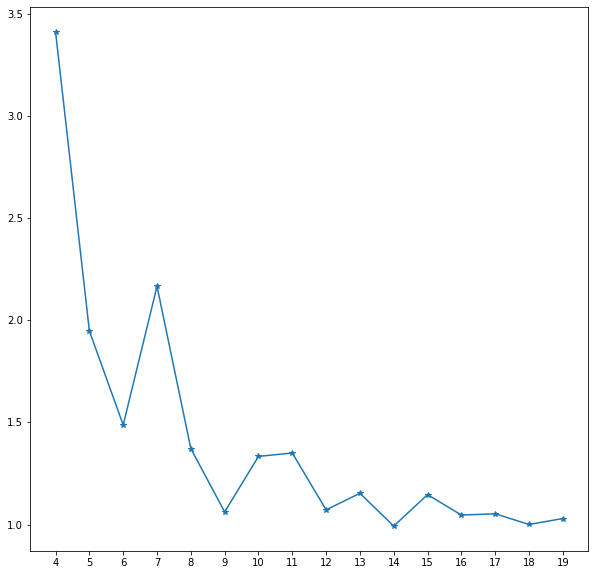

In [36]:
res = cluster_nums[1:]

plt.xticks(np.arange(min(res), max(res)+1, 1.0))
plt.plot(res, drop_rates[1:], '-*')
plt.show()

In [34]:
drop_rates

array([-1.36311572e+57,  3.41012518e+00,  1.94719788e+00,  1.48717052e+00,
        2.16573557e+00,  1.37161749e+00,  1.06182717e+00,  1.33348387e+00,
        1.35020224e+00,  1.07209336e+00,  1.15307920e+00,  9.92575588e-01,
        1.14655564e+00,  1.04653207e+00,  1.05274672e+00,  1.00046172e+00,
        1.02960078e+00])

In [44]:
np.empty(0)

array([], dtype=float64)

In [45]:
cluster_nums

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])

In [46]:
np.arange(0, 10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])